In [ ]:
# !pip install jupyter_black
# import jupyter_black
# jupyter_black.load()

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

from sklearn.linear_model import Ridge, RidgeCV

RS = 42

# Задача со звездочкой 10. Happiness.
Возьмите большой социологический датасет (например, World Value Survey) и узнайте, наконец, что делает людей счастливыми. Дизайн исследования на ваше усмотрение.

Оценка ставится, если вы присылаете читаемый и прокомментированный ноутбук, в котором отсутствуют ошибки дизайна исслледований, о которых мы говорили сегодня. Еще, мне будет гораздо приятнее проверять работы, в которых у вас получается выудить какой-то нетривиальный паттерн в этих данных, а не "инсоляция и доход повышают expexted happiness, a войны -- понижаю".

## World Happiness Report- 2024
The World Happiness Report is a landmark survey of the state of global happiness . The report continues to gain global recognition as governments, organizations and civil society increasingly use happiness indicators to inform their policy-making decisions. Leading experts across fields – economics, psychology, survey analysis, national statistics, health, public policy and more – describe how measurements of well-being can be used effectively to assess the progress of nations. The reports review the state of happiness in the world today and show how the new science of happiness explains personal and national variations in happiness.

1. Country name: Name of the country.

2. Year

3. Life ladder: The happiness score for each country, based on responses to the Cantril Ladder question that asks respondents to think of a ladder, with the best possible life for them being a 10, and the worst possible life being a 0.

4. Log GDP per capita: The natural logarithm of the country's GDP per capita, adjusted for purchasing power parity (PPP) to account for differences in the cost of living between countries.

5. Social support: The national average of binary responses(either 0 or 1 representing No/Yes) to the question about having relatives or friends to count on in times of trouble.

6. Healthy life expectancy: The average number of years a newborn infant would live in good health, based on mortality rates and life expectancy at different ages.

7. Freedom to make life choices: The national average of responses to the question about satisfaction with freedom to choose what to do with one's life.

8. Generosity: The residual of regressing the national average of responses to the question about donating money to charity on GDP per capita.

9. Perceptions of corruption: The national average of survey responses to questions about the perceived extent of corruption in the government and businesses.

10. Positive affect: The national average of responses to questions about positive emotions experienced yesterday.

11. Negative affect: The national average of responses to questions about negative emotions experienced yesterday.xperienced yesterday.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jainaru/world-happiness-report-2024-yearly-updated")

df = pd.read_csv(path+"/World-happiness-report-updated_2024.csv", encoding='latin-1')

df

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
...,...,...,...,...,...,...,...,...,...,...,...
2358,Zimbabwe,2019,2.694,7.698,0.759,53.100,0.632,-0.051,0.831,0.658,0.235
2359,Zimbabwe,2020,3.160,7.596,0.717,53.575,0.643,0.003,0.789,0.661,0.346
2360,Zimbabwe,2021,3.155,7.657,0.685,54.050,0.668,-0.079,0.757,0.610,0.242
2361,Zimbabwe,2022,3.296,7.670,0.666,54.525,0.652,-0.073,0.753,0.641,0.191


## 1. Подготовим данные для исследования

In [ ]:
pd.DataFrame(
    round(
        df.isna().mean() * 100,
    )
).style.background_gradient("coolwarm")

,0
Country name,0.000000
year,0.000000
Life Ladder,0.000000
Log GDP per capita,1.000000
Social support,1.000000
Healthy life expectancy at birth,3.000000
Freedom to make life choices,2.000000
Generosity,3.000000
Perceptions of corruption,5.000000
Positive affect,1.000000


In [ ]:
df = df.dropna(ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 180.3+ KB


In [ ]:
df["Country name"] = df["Country name"].astype('category')

In [ ]:
X = df.drop(["Life Ladder"], axis=1)
y = df["Life Ladder"]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Country name                      2097 non-null   category
 1   year                              2097 non-null   int64   
 2   Log GDP per capita                2097 non-null   float64 
 3   Social support                    2097 non-null   float64 
 4   Healthy life expectancy at birth  2097 non-null   float64 
 5   Freedom to make life choices      2097 non-null   float64 
 6   Generosity                        2097 non-null   float64 
 7   Perceptions of corruption         2097 non-null   float64 
 8   Positive affect                   2097 non-null   float64 
 9   Negative affect                   2097 non-null   float64 
dtypes: category(1), float64(8), int64(1)
memory usage: 156.9 KB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RS)

In [ ]:
categorical_columns = X.select_dtypes(include='category').columns
numerical_columns = X._get_numeric_data().columns

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="first", handle_unknown='ignore'), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder="passthrough"
)

# numerical_columns = X._get_numeric_data().columns
# preprocessor = make_column_transformer(
#     (StandardScaler(), numerical_columns),
#     remainder="passthrough"
# )


## 2. Исследование

### 2.1. Совместное распределение

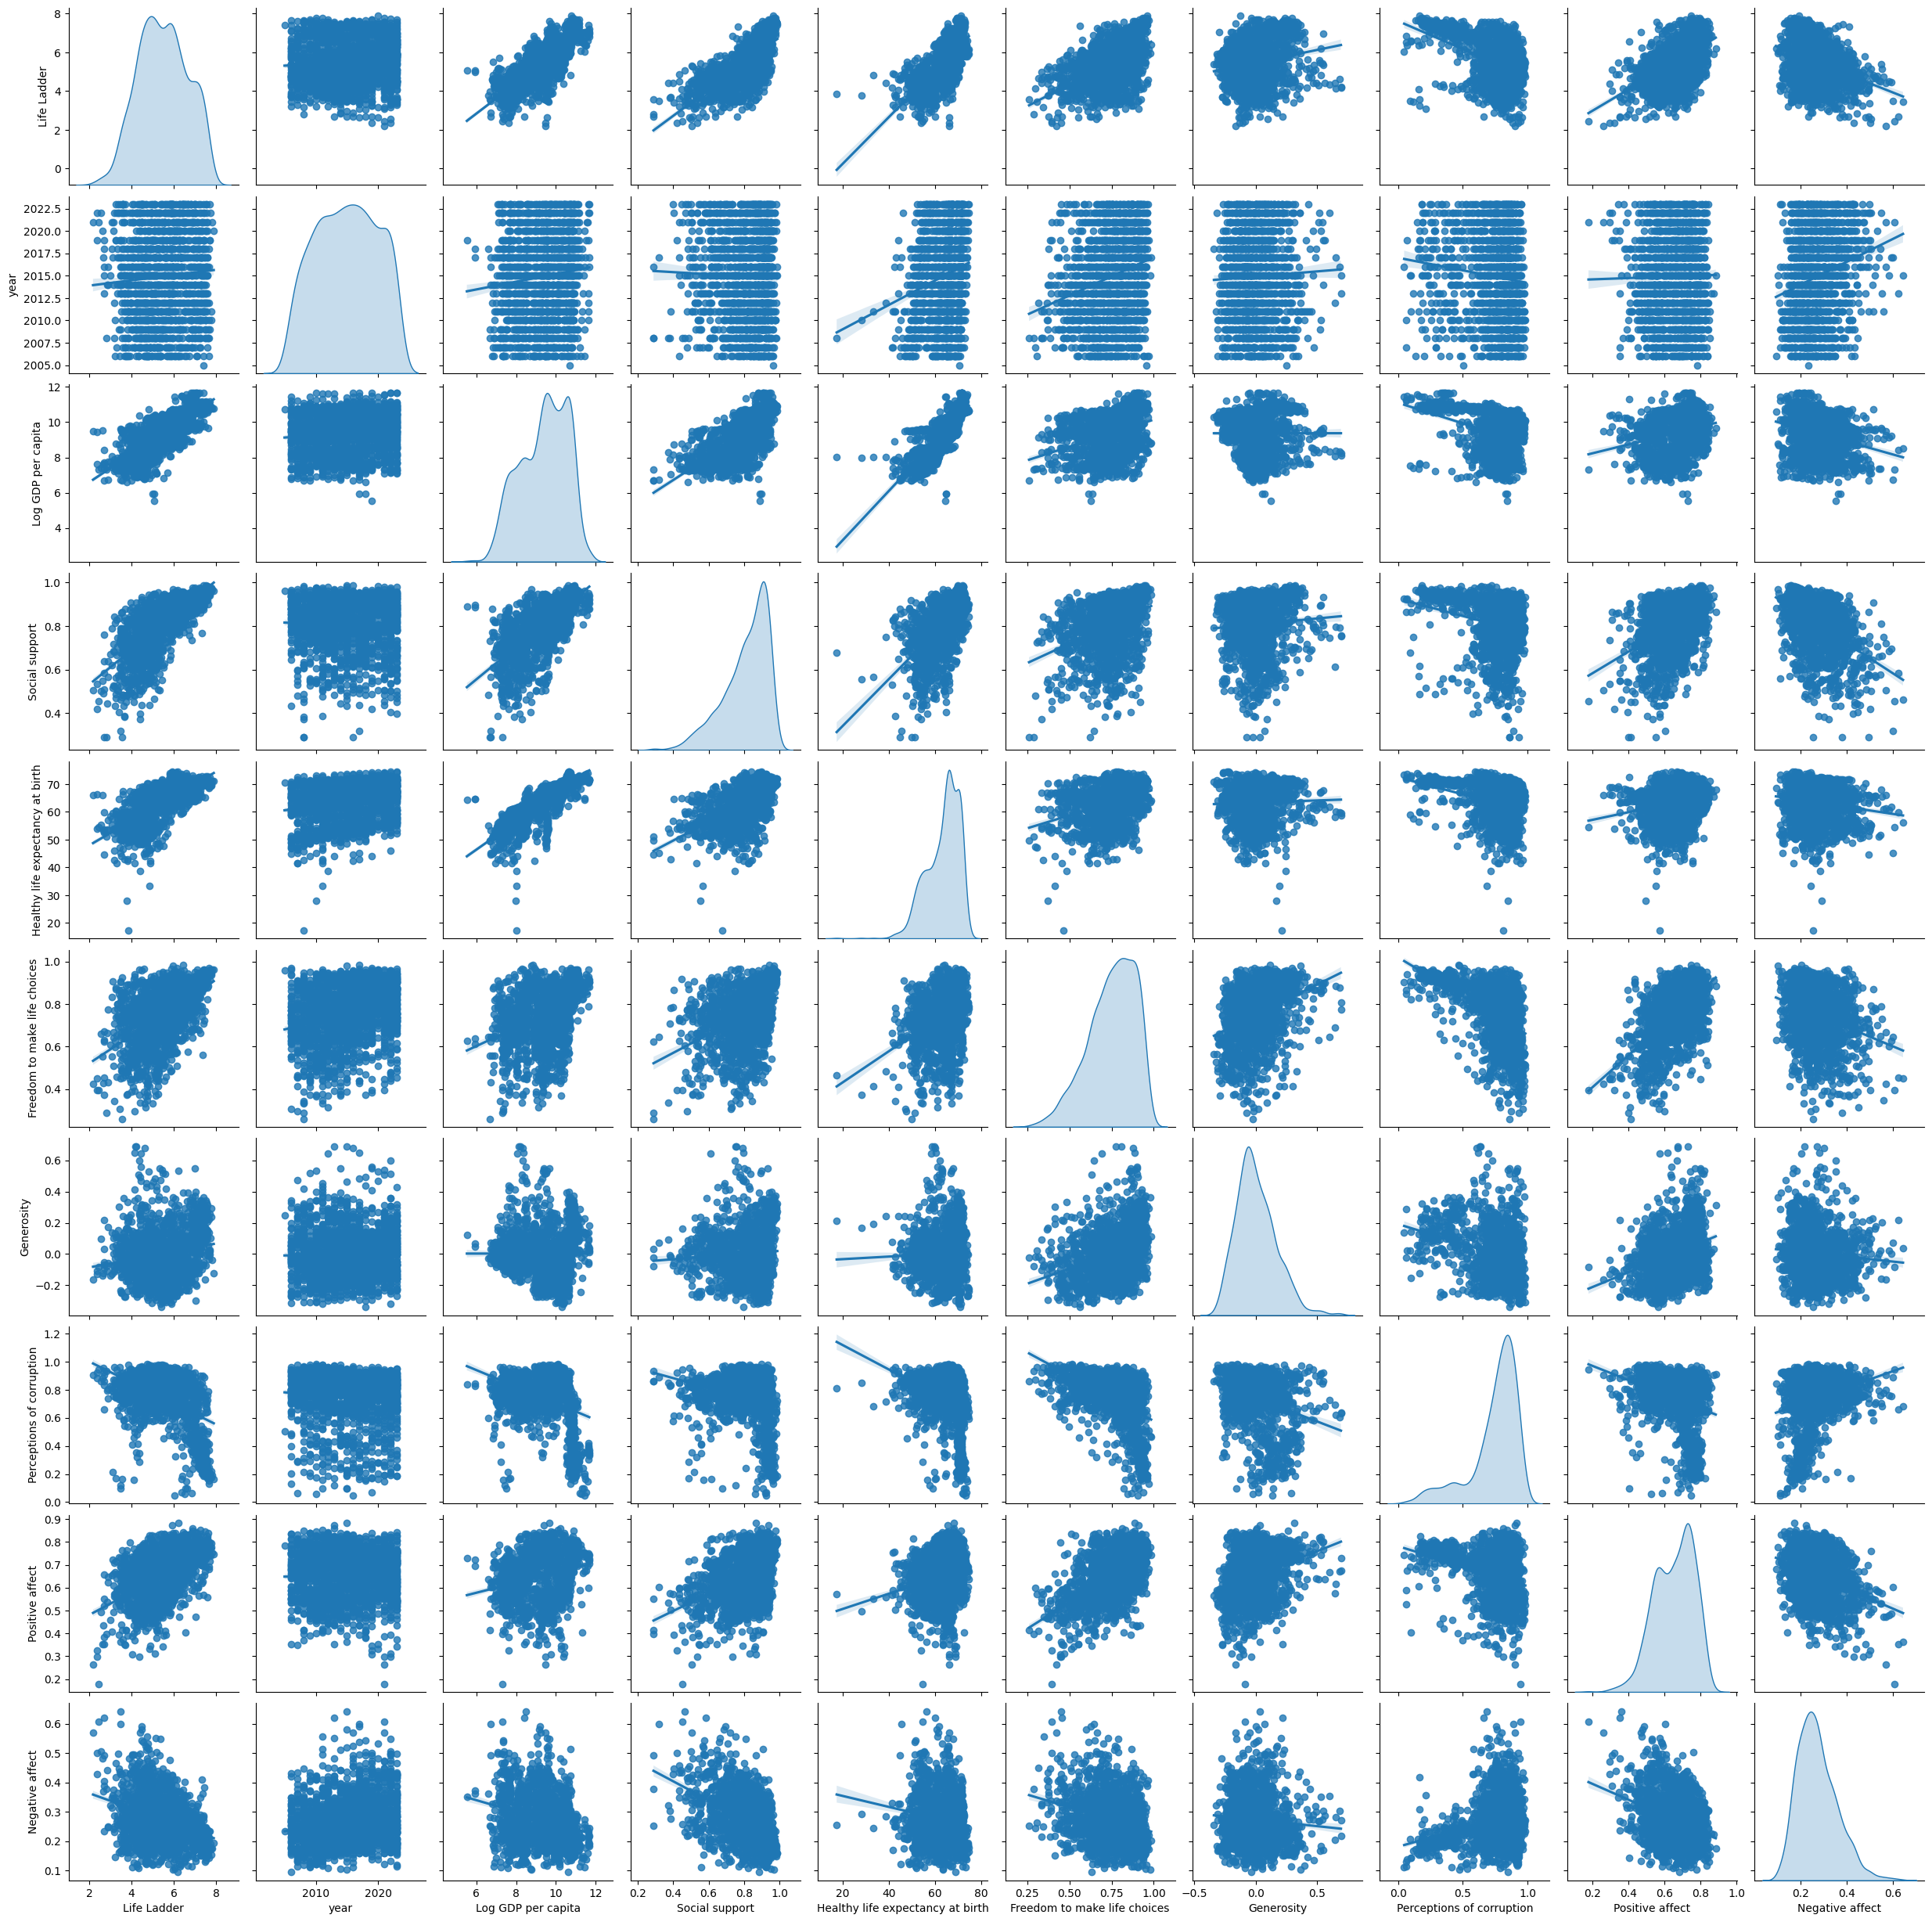

In [ ]:
train_dataset = X_train.copy()
train_dataset.insert(0, "Life Ladder", y_train)
_ = sns.pairplot(
    train_dataset,
    kind="reg",
    diag_kind="kde"
)

Наиболее высокая корреляция надлюдается у признака продолжительности жизни и ВВП

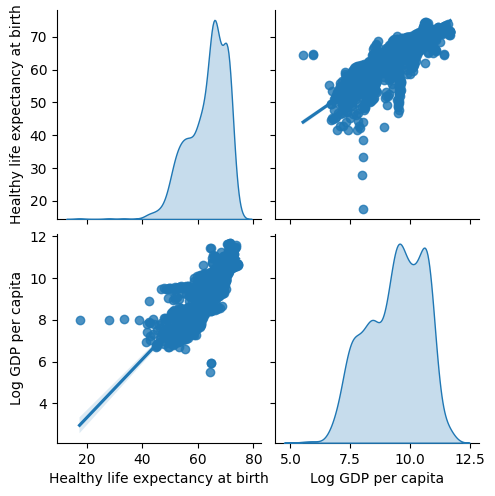

In [ ]:
_ = sns.pairplot(
    train_dataset[["Healthy life expectancy at birth", "Log GDP per capita"]],
    kind="reg",
    diag_kind="kde"
)

### Распределение целевой переменной

(array([  2.,   2.,   8.,   4.,   4.,  13.,  28.,  37.,  43.,  40.,  61.,
         87.,  80.,  93.,  92.,  98.,  79.,  82.,  80., 109.,  73.,  75.,
         67.,  45.,  52.,  61.,  59.,  57.,  35.,   6.]),
 array([2.179     , 2.36933333, 2.55966667, 2.75      , 2.94033333,
        3.13066667, 3.321     , 3.51133333, 3.70166667, 3.892     ,
        4.08233333, 4.27266667, 4.463     , 4.65333333, 4.84366667,
        5.034     , 5.22433333, 5.41466667, 5.605     , 5.79533333,
        5.98566667, 6.176     , 6.36633333, 6.55666667, 6.747     ,
        6.93733333, 7.12766667, 7.318     , 7.50833333, 7.69866667,
        7.889     ]),
 <BarContainer object of 30 artists>)

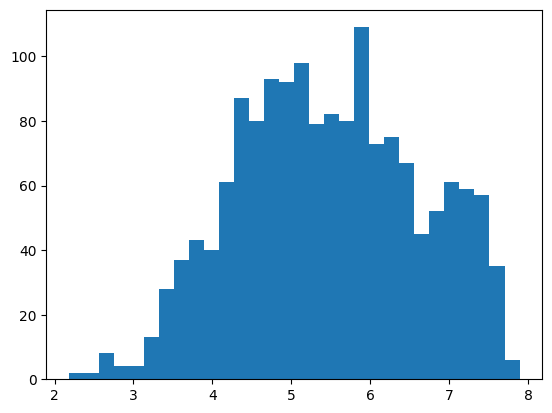

In [ ]:
plt.hist((y_train), bins=30)

Не так уж и далеко от нормального

In [ ]:
print(sp.stats.normaltest((y_train)))

NormaltestResult(statistic=84.03255586500056, pvalue=5.656689541190004e-19)


Но судя по p-value далеко...

(array([  1.,   1.,   2.,   1.,   6.,   2.,   3.,   2.,   9.,   8.,  21.,
         29.,  36.,  35.,  39.,  69.,  92.,  83., 102., 109., 101., 100.,
        108., 131., 100.,  87.,  77.,  91.,  94.,  33.]),
 array([0.77886606, 0.82175283, 0.86463961, 0.90752639, 0.95041317,
        0.99329994, 1.03618672, 1.0790735 , 1.12196028, 1.16484705,
        1.20773383, 1.25062061, 1.29350739, 1.33639416, 1.37928094,
        1.42216772, 1.4650545 , 1.50794128, 1.55082805, 1.59371483,
        1.63660161, 1.67948839, 1.72237516, 1.76526194, 1.80814872,
        1.8510355 , 1.89392227, 1.93680905, 1.97969583, 2.02258261,
        2.06546938]),
 <BarContainer object of 30 artists>)

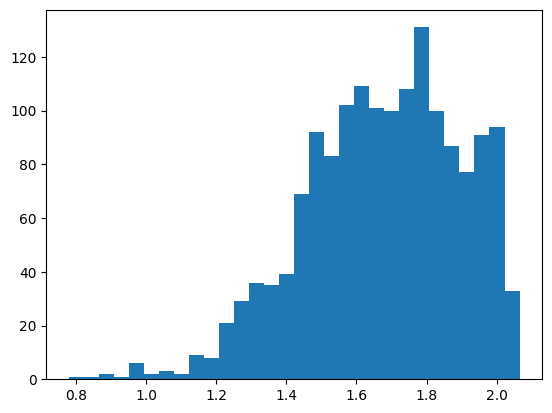

In [ ]:
plt.hist(np.log(y_train), bins=30)

In [ ]:
print(sp.stats.normaltest(np.log(y_train)))

NormaltestResult(statistic=65.91722317077384, pvalue=4.8557560201318034e-15)


После логарифмирования стало еще хуже, ничего предпринимать не будем

> Add blockquote



## 3. Обучение модели

При решении с ridge столкнулся с ошибкой: cg() got an unexpected keyword argument 'tol'

Так и не смог ее решить.

Начнем сразу с GridSearch

С RidgeCV тоже особо невиданная в интернете ошибка...
'csr_matrix' object has no attribute 'A'

Поэтому я перешел на colab... Тут нет несовместимости версий, хотя на kaggle самые новые версии

In [ ]:
alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation

model = make_pipeline(
    preprocessor,
    RidgeCV(alphas=alphas),
)

In [ ]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['Country name'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['year', 'Log GDP per capita', 'Social support',
       'Healthy life expectancy at birth', 'Freedom to make life choices',
       'Generosity', 'Perceptions of corruption', 'Positive affect',
       'Negative affect'],
      dtype='object'))])),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])))])

### 3.1. Регуляризация

Сразу нормализуем и регуляризируем переменные.

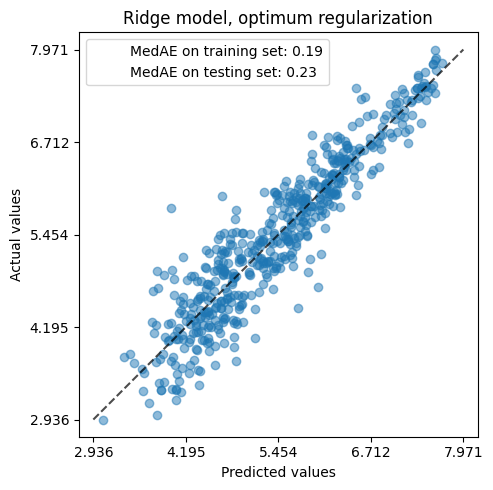

In [ ]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f}",
    "MedAE on testing set": f"{mae_test:.2f}",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

### 3.2. Коэффициенты признаков

In [ ]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs

,Coefficients importance
onehotencoder__Country name_Albania,0.071436
onehotencoder__Country name_Algeria,0.131649
onehotencoder__Country name_Angola,-0.028124
onehotencoder__Country name_Argentina,0.217557
onehotencoder__Country name_Armenia,0.078643
...,...
standardscaler__Freedom to make life choices,0.098617
standardscaler__Generosity,0.059016
standardscaler__Perceptions of corruption,-0.096708
standardscaler__Positive affect,0.230598


В датасете очень много стран. Проанализируем их отдельно от всех признаков

In [ ]:
country_coefs = coefs[coefs.index.str.contains('Country name')]
country_coefs

,Coefficients importance
onehotencoder__Country name_Albania,0.071436
onehotencoder__Country name_Algeria,0.131649
onehotencoder__Country name_Angola,-0.028124
onehotencoder__Country name_Argentina,0.217557
onehotencoder__Country name_Armenia,0.078643
...,...
onehotencoder__Country name_Venezuela,0.557225
onehotencoder__Country name_Vietnam,0.066988
onehotencoder__Country name_Yemen,-0.187543
onehotencoder__Country name_Zambia,-0.371978


In [ ]:
other_coefs = coefs[~coefs.index.str.contains('Country name')]
other_coefs

,Coefficients importance
standardscaler__year,-0.010361
standardscaler__Log GDP per capita,0.470055
standardscaler__Social support,0.221943
standardscaler__Healthy life expectancy at birth,0.089871
standardscaler__Freedom to make life choices,0.098617
standardscaler__Generosity,0.059016
standardscaler__Perceptions of corruption,-0.096708
standardscaler__Positive affect,0.230598
standardscaler__Negative affect,-0.082267


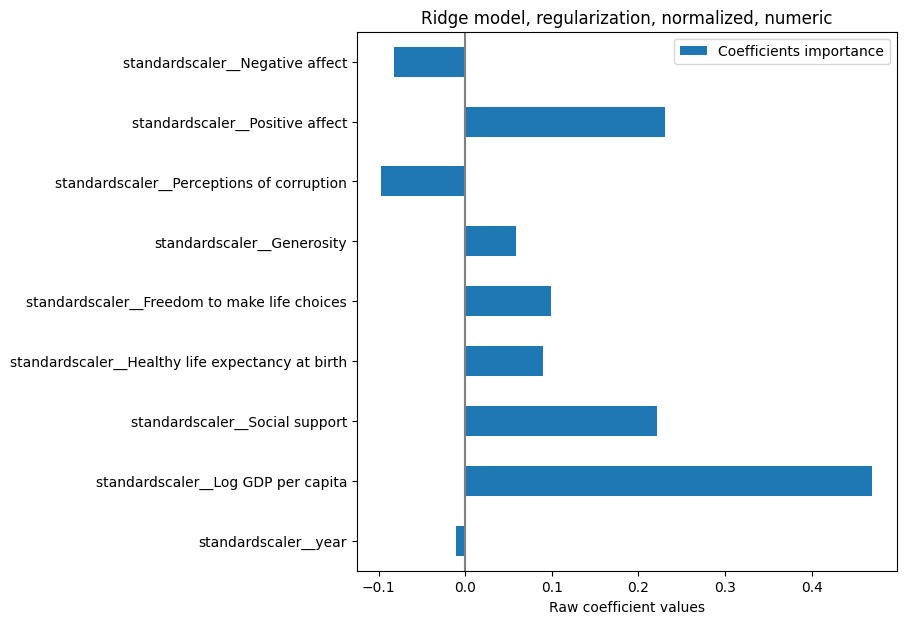

In [ ]:
other_coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, regularization, normalized, numeric")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

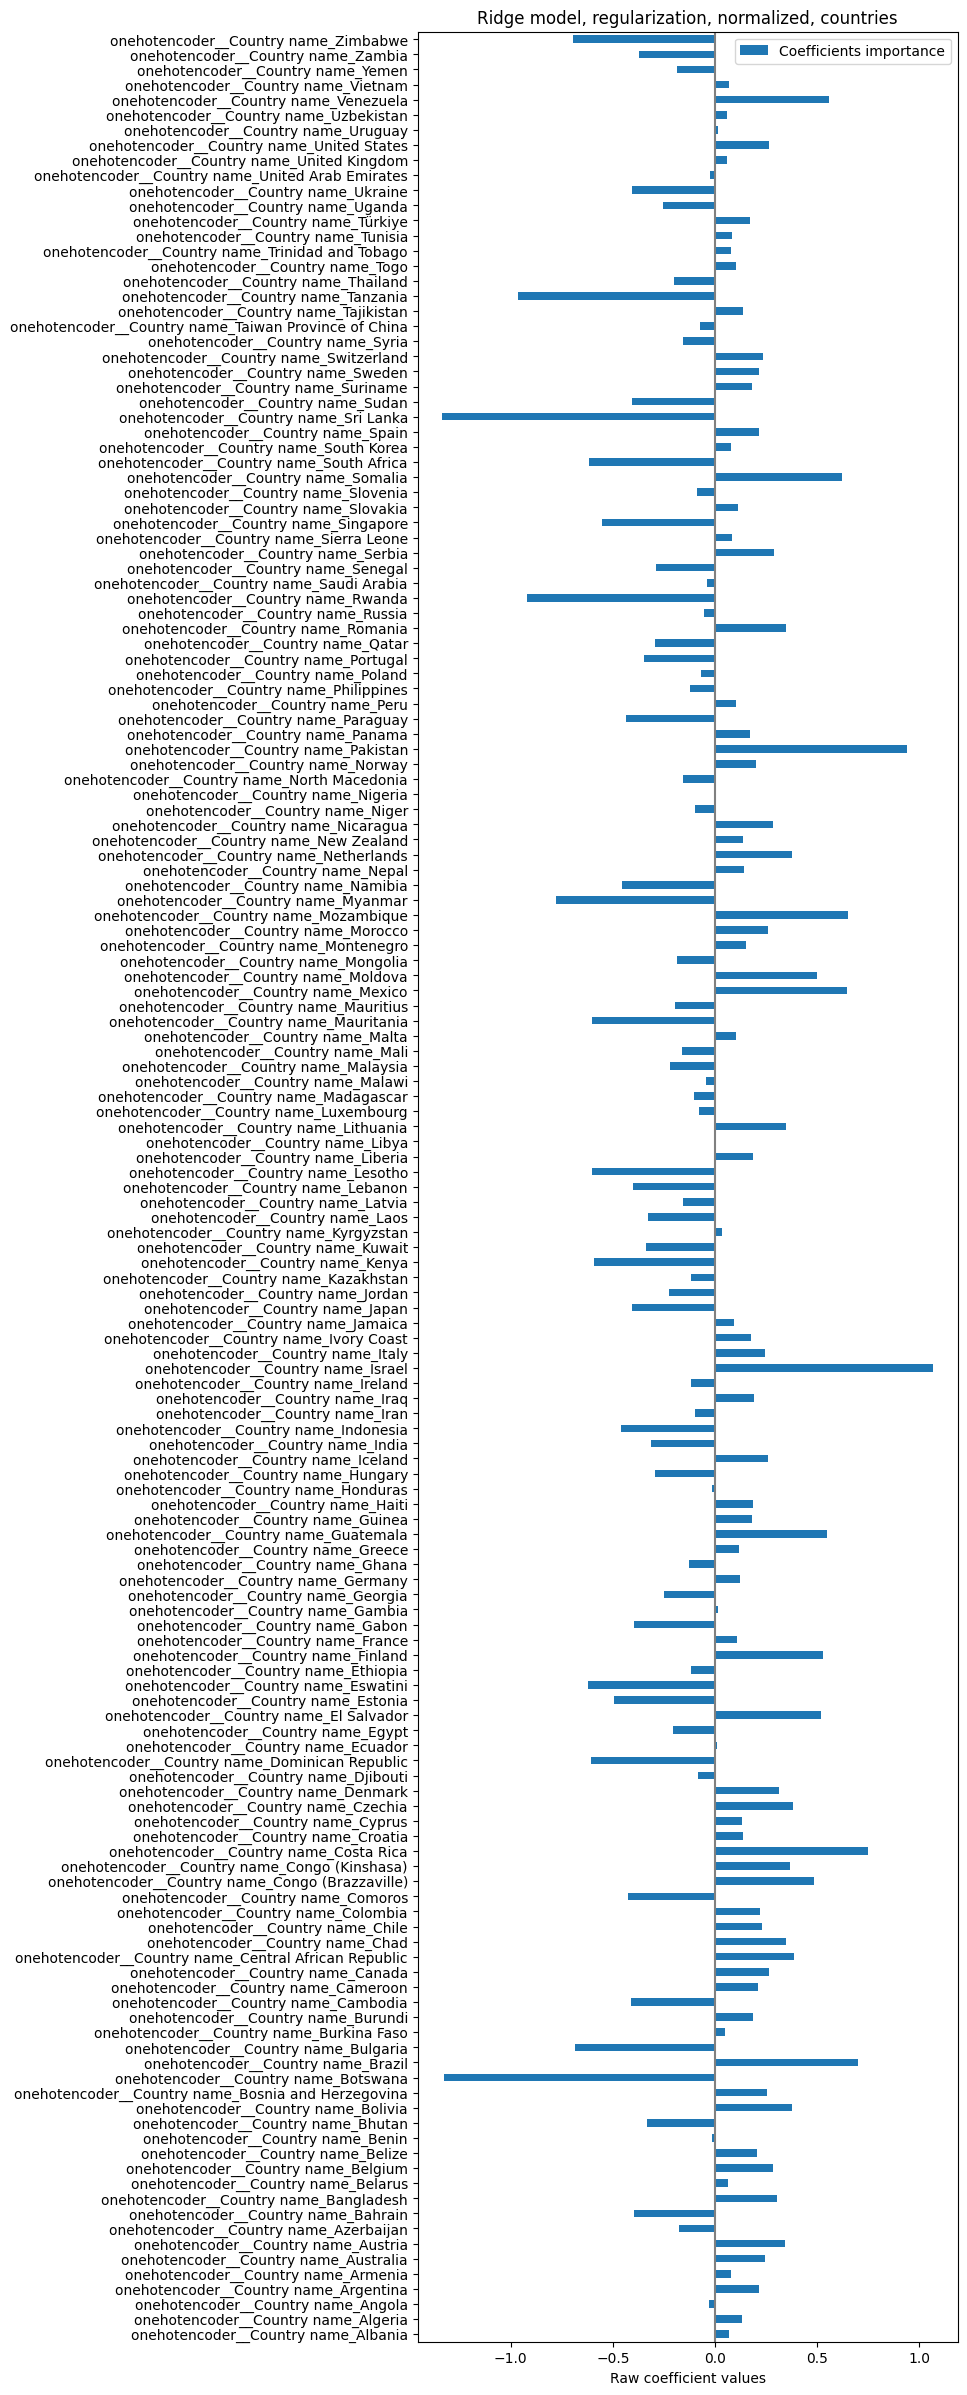

In [ ]:
country_coefs.plot.barh(figsize=(9, 30))
plt.title("Ridge model, regularization, normalized, countries")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

### 3.3. Ящики с усами
Рассмотрим их отдельно, без стран.Т.к. при разделении во время CV отсутствуют некоторые страны и OHE выдает разное кол-во признаков.

Видимо при разделении во время CV отсутствуют некоторые страны и OHE выдает разное кол-во признаков.

In [ ]:
X = df.drop(["Life Ladder", "Country name"], axis=1)
y = df["Life Ladder"]

X.info()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RS)

numerical_columns = X._get_numeric_data().columns
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),
    remainder="passthrough"
)

alphas = np.logspace(-10, 10, 21)

model = make_pipeline(
    preprocessor,
    RidgeCV(alphas=alphas),
)

model.fit(X_train, y_train)

feature_names = model[:-1].get_feature_names_out()

# coefs = pd.DataFrame(
#     model[-1].coef_,
#     columns=["Coefficients importance"],
#     index=feature_names,
# )

coefs = pd.DataFrame(
    [
        est[-1].coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              2097 non-null   int64  
 1   Log GDP per capita                2097 non-null   float64
 2   Social support                    2097 non-null   float64
 3   Healthy life expectancy at birth  2097 non-null   float64
 4   Freedom to make life choices      2097 non-null   float64
 5   Generosity                        2097 non-null   float64
 6   Perceptions of corruption         2097 non-null   float64
 7   Positive affect                   2097 non-null   float64
 8   Negative affect                   2097 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 147.6 KB


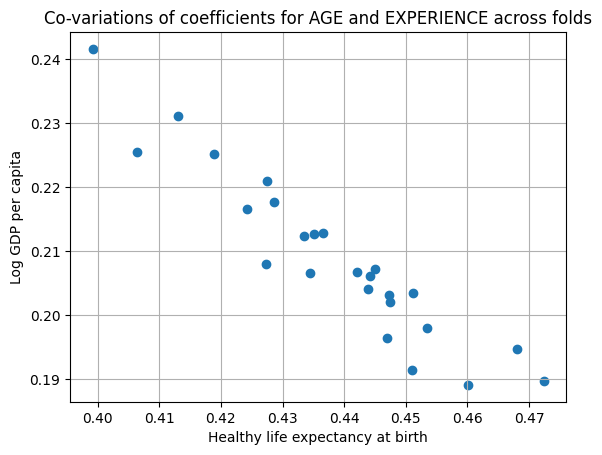

In [ ]:
plt.ylabel("Log GDP per capita")
plt.xlabel("Healthy life expectancy at birth")
plt.grid(True)
plt.scatter(coefs["standardscaler__Log GDP per capita"], coefs["standardscaler__Healthy life expectancy at birth"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

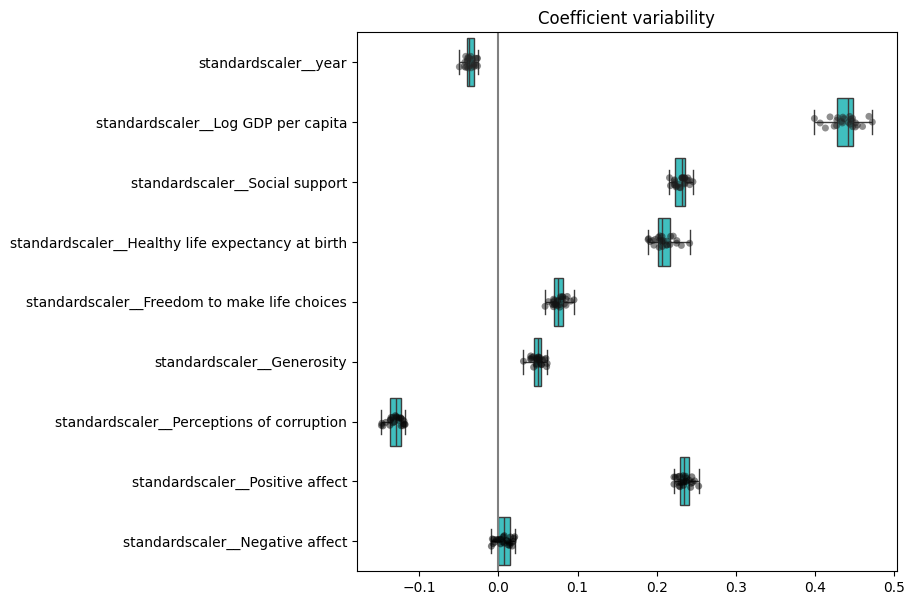

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].coef_ for est in cv_model["estimator"]], columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

Несмотря на корреляцию между долголетием и ВВП, признаки распределены адекватным образом

## 4. Что делает людей счастливыми?

### 4.1. Числовые признаки

Исходя из пункта 3.1.:
1. На людей во время опроса значительно влияли недавние события: Negative and Positive affect - в отрицательную и положительную стороны соответственно. Очевидно, что наше настроение меняется в зависимости от пережитого положительного или негативного опыта. Тем не менее неправильно говорить, что это влияет на счастье в целом, т.к. это состояние аффекта.
2. Процент коррупции негативно влияет на счастье населения. Очень интересный факт на заметку госслужащих)
3. Generosity - траты на благотворительность. Чем выше траты, тем больше пострадавших людей счастливы.
4. Свобода выбора. Так же очевидный признак - чем больше людей могут выбирать свою судьбу, тем больше счастливчиков.
5. Продолжительность жизни, социальная поддержка и ВВП - очевидные признаки, рост которых значительно влияет на счастье.
6. Год опроса в совокупности по странам не влияет на счастье. Пожалуй его было бы интересно рассмотреть, но по отдельным странам - во времена кризисов, войн и т.д. Слишком трудоемкая работа и недостаток данных.

### 4.2. Страны

#### Наиболее негативное влияние на счастье:
1. Шри-Ланка
2. Бонсвана
3. Танзания
Также зимбабве, Южная Африка, Руанда Намибия и другие бедные страны третьего мира.

#### Наиболее позитивное влияние на счастье:
1. Израиль
2. Пакистан
3. Коста Рика

Израиль - понятно.

Коста Рика - стабильная экономика, высокий уровень образованности; Коста-Рика считается одним из самых зелёных мест на планете, высокий уровень медицины; по сравнению с другими странами Латинской Америки, Коста-Рика — самая безопасная и политически стабильная (https://www.relocationcostarica.com/why-costa-rica-good-place-move-ru).

Пакистан - очень интересно...

#### Из интересного можно заметить то, что крупные страны, страны 1 мира, - стабильны. Значительного влияния на счастье нет. В России один из самых близких к 0 коэффициентов.